# Method development - betas with geometric functions

09/03/20

Aims:

- Develop $\beta_{L,M}$ formalism.
- Develop corresponding numerical methods.
- Speed things up (see [low-level benchmarking notebook](https://epsproc.readthedocs.io/en/dev/tests/Low_level_bench_tests_Wigner3j_Feb2020.html)).
- Analyse geometric terms.

For individual functions, see http://localhost:8888/lab/tree/dev/ePSproc/geometric_method_dev_260220.ipynb

## Setup

In [1]:
# Imports
import numpy as np
import pandas as pd
import xarray as xr
from functools import lru_cache  # For function result caching

# Special functions
# from scipy.special import sph_harm
import spherical_functions as sf
import quaternion

# Performance & benchmarking libraries
# from joblib import Memory
# import xyzpy as xyz
import numba as nb

# Timings with ttictoc
# https://github.com/hector-sab/ttictoc
# from ttictoc import TicToc

# Package fns.
# For module testing, include path to module here
import sys
import os
modPath = r'D:\code\github\ePSproc'  # Win test machine
# modPath = r'/home/femtolab/github/ePSproc/'  # Linux test machine
sys.path.append(modPath)
import epsproc as ep
# TODO: tidy this up!
from epsproc.util import matEleSelector
from epsproc.geomFunc import geomCalc

* pyevtk not found, VTK export not available. 


In [2]:
# Load data from modPath\data
dataPath = os.path.join(modPath, 'data', 'photoionization')
dataFile = os.path.join(dataPath, 'n2_3sg_0.1-50.1eV_A2.inp.out')  # Set for sample N2 data for testing

# Scan data file
dataSet = ep.readMatEle(fileIn = dataFile)
dataXS = ep.readMatEle(fileIn = dataFile, recordType = 'CrossSection')  # XS info currently not set in NO2 sample file.

*** ePSproc readMatEle(): scanning files for DumpIdy segments.

*** Scanning file(s)
['D:\\code\\github\\ePSproc\\data\\photoionization\\n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 102 DumpIdy segments.
Found 102 dumpIdy segments (sets of matrix elements).

Processing segments to Xarrays...
Processed 102 sets of DumpIdy file segments, (0 blank)
*** ePSproc readMatEle(): scanning files for CrossSection segments.

*** Scanning file(s)
['D:\\code\\github\\ePSproc\\data\\photoionization\\n2_3sg_0.1-50.1eV_A2.inp.out']

*** Reading ePS output file:  D:\code\github\ePSproc\data\photoionization\n2_3sg_0.1-50.1eV_A2.inp.out
Expecting 51 energy points.
Expecting 2 symmetries.
Scanning CrossSection segments.
Expecting 3 CrossSection segments.
Found 3 CrossSection segments (sets of results).
Processed 3 sets of Cro

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data n2_3sg_0.1-50.1eV_A2.inp.out, pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


l                          1                            3                    
m                         -1        0         1        -1         0         1
Cont Targ Total mu                                                           
PU   SG   PU    -1       NaN      NaN -6.203556       NaN       NaN -2.090641
                 1 -6.203556      NaN       NaN -2.090641       NaN       NaN
SU   SG   SU     0       NaN  6.24652       NaN       NaN  2.605768       NaN

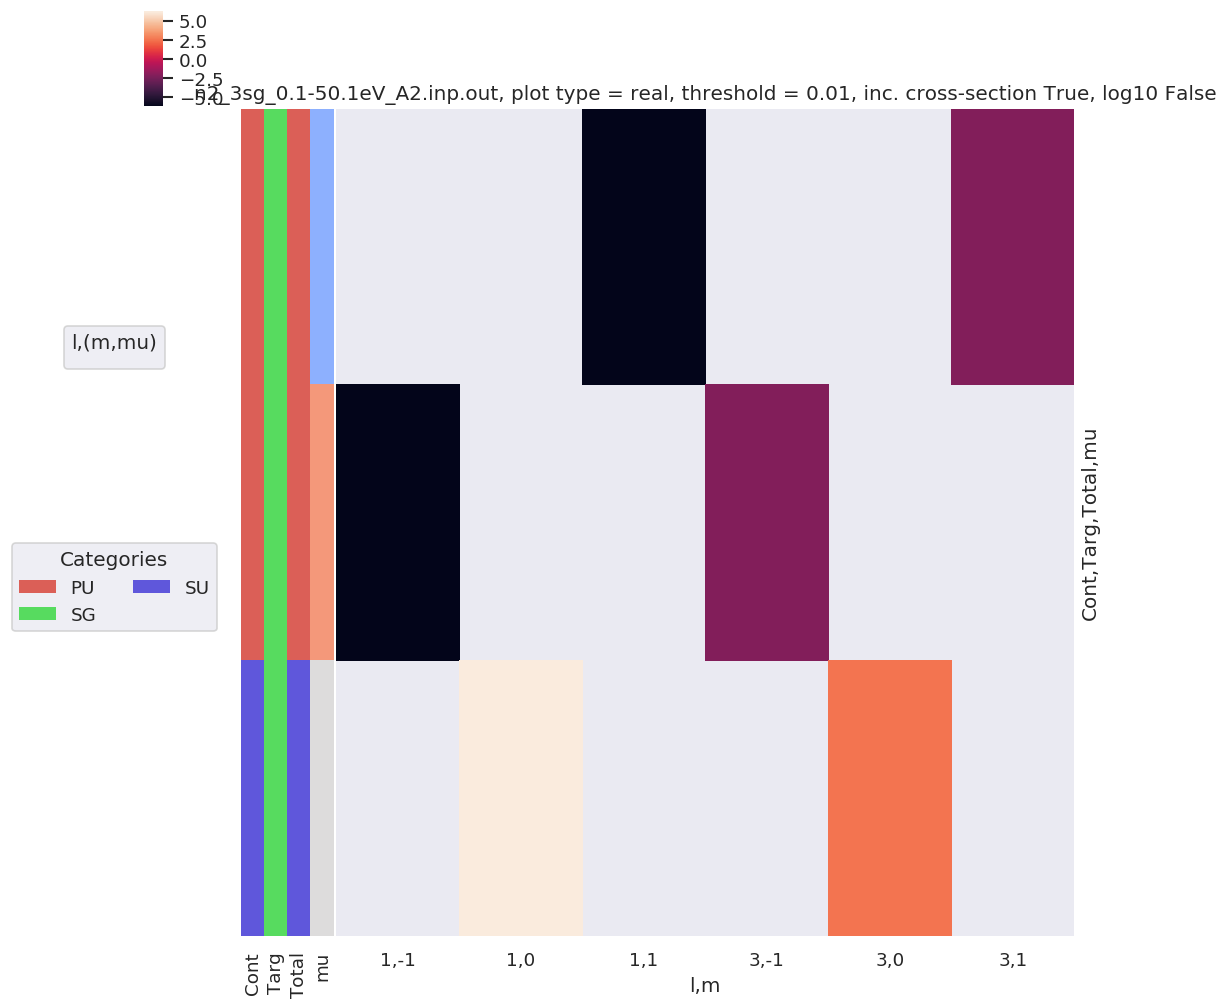

In [21]:
# Set for a single set of matrix elements for testing
matE = ep.matEleSelector(dataSet[0], thres = 1e-2, inds = {'Eke':0.1, 'it':1, 'Type':'L'})

# Plot vs. (l,m)
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matE, plotDims = ['Cont', 'Targ', 'Total', 'mu'], xDim = {'LM':['l','m']}, pType = 'r')
daPlotpd

In [35]:
# Test muiltiplication by pairs...
matEconj = matE.copy().conj()
matEconj = matEconj.unstack().rename({'l':'lp','m':'mp','mu':'mup'})

matEmult = matEconj * matE.unstack()
matEmult.attrs['dataType'] = 'multTest'

In [33]:
matEmult.coords

Coordinates:
    Ehv      float64 15.68
    Eke      float64 0.1
    Type     <U1 'L'
    it       int64 1
  * mup      (mup) int64 -1 0 1
    SF       complex128 (2.1560627+3.741674j)
  * lp       (lp) int64 1 3
  * mp       (mp) int64 -1 0 1
  * Cont     (Cont) object 'PU' 'SU'
  * Targ     (Targ) object 'SG'
  * Total    (Total) object 'PU' 'SU'
  * mu       (mu) int64 -1 0 1
  * l        (l) int64 1 3
  * m        (m) int64 -1 0 1

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\envs\ePSdev\lib\site-packages\xarray\core\nputils.py:215: RuntimeWarning:

All-NaN slice encountered



Plotting data (No filename), pType=r, thres=0.01, with Seaborn


No handles with labels found to put in legend.


l                                    1                             3  \
m                                   -1         0         1        -1   
Cont Targ Total lp mp mu mup                                           
PU   SG   PU    1  -1 -1  1        NaN       NaN  3.556042       NaN   
                       1  1   3.556042       NaN       NaN  0.248403   
                    1 -1 -1        NaN       NaN  3.556042       NaN   
                       1 -1   3.556042       NaN       NaN  0.248403   
                3  -1 -1  1        NaN       NaN  0.248403       NaN   
                       1  1   0.248403       NaN       NaN  0.368290   
                    1 -1 -1        NaN       NaN  0.248403       NaN   
                       1 -1   0.248403       NaN       NaN  0.368290   
SU   SG   SU    1   0  0  0        NaN  7.496043       NaN       NaN   
                3   0  0  0        NaN -0.395799       NaN       NaN   

l                                                 
m                                    0         1  
Cont Targ Total lp mp mu mup                      
PU   SG   PU    1  -1 -1  1        NaN  0.248403  
                       1  1        NaN       NaN  
                    1 -1 -1        NaN  0.248403  
                       1 -1        NaN       NaN  
                3  -1 -1  1        NaN  0.368290  
                       1  1        NaN       NaN  
                    1 -1 -1        NaN  0.368290  
                       1 -1        NaN       NaN  
SU   SG   SU    1   0  0  0  -0.395799       NaN  
                3   0  0  0   0.661931       NaN

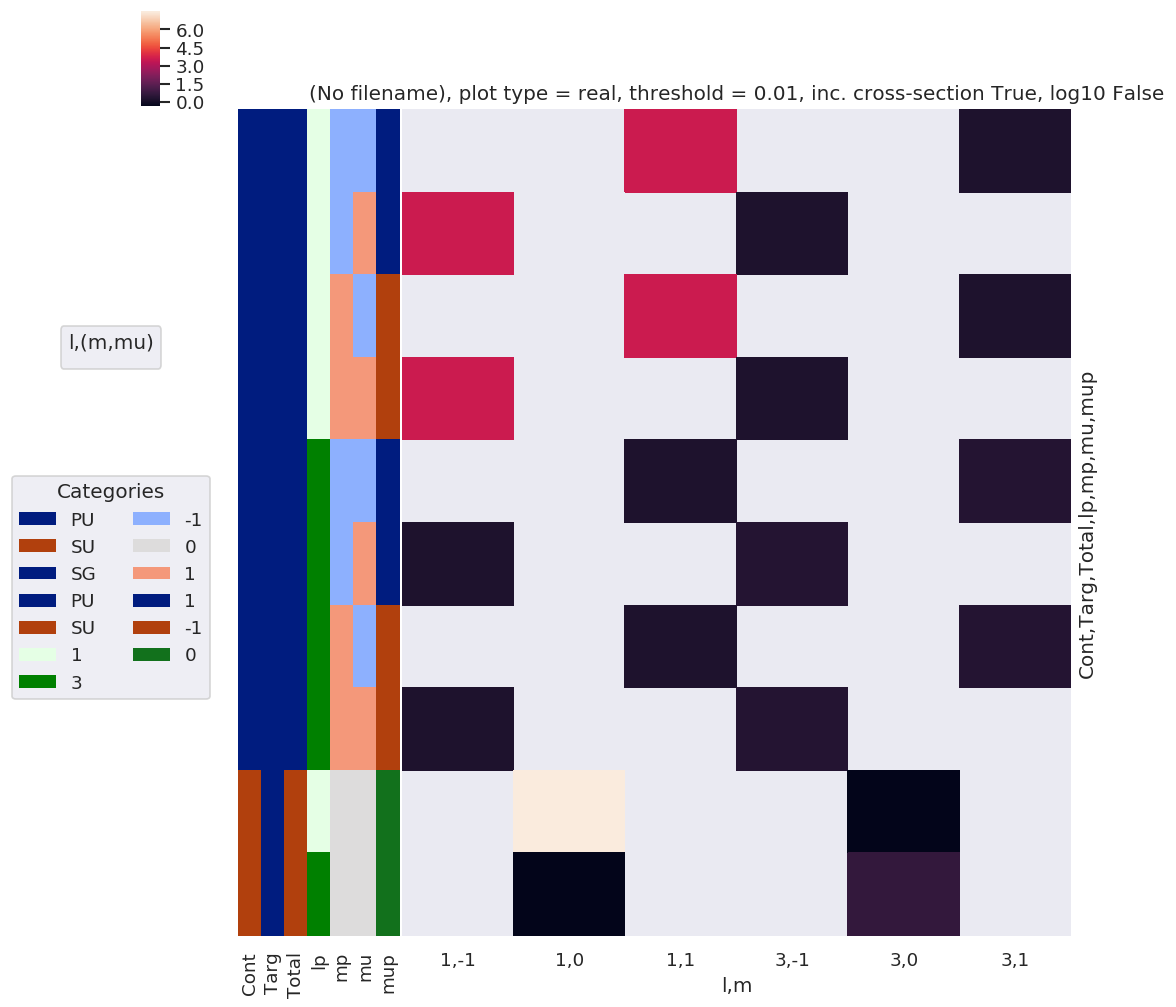

In [36]:
# Plot vs. (l,m)
daPlot, daPlotpd, legendList, gFig = ep.lmPlot(matEmult, plotDims = ['Cont', 'Targ', 'Total', 'lp', 'mp', 'mu', 'mup'], xDim = {'LM':['l','m']}, pType = 'r')
daPlotpd